In [1]:
!pip install datasets
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
!pip install transformers
!pip install evaluate
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
!pip install --upgrade accelerate==0.21.0
!pip install transformers==4.31.0
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"Is CUDA available: {torch.cuda.is_available()}")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


PyTorch version: 2.3.0+cu121
Is CUDA available: True


In [2]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Training


In [3]:
from transformers import TrainingArguments, Trainer, AutoModelForSequenceClassification, AutoTokenizer, EarlyStoppingCallback, get_linear_schedule_with_warmup, DataCollatorWithPadding
from datasets import Dataset
import torch
import pandas as pd

# Load your DataFrame
# Example: df = pd.read_csv('your_dataset.csv')
# df = pd.read_csv('your_dataset.csv')  # Load your dataset here
file_path="spam.csv"
df = pd.read_csv('/content/drive/MyDrive/CS614/spam.csv', encoding = "ISO-8859-1")

# Keep only necessary columns and map labels
df = df[["v1", "v2"]]  # Filter to only include columns v1 (label) and v2 (text)
df['label'] = df.v1.map({'ham': 0, 'spam': 1})  # Map 'ham' to 0 and 'spam' to 1

# Initialize the tokenizer
tokenizer = AutoTokenizer.from_pretrained('bert-base-cased')

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Calculate the number of samples
total_rows = len(df)
train_size = int(total_rows * 0.7)  # 70% for training
eval_size = int(total_rows * 0.15)  # 15% for evaluation
test_size = int(total_rows * 0.15)  # 15% for testing

# Sample the DataFrame
train_data_df = df.sample(train_size, random_state=42)
remaining_df = df.drop(train_data_df.index)  # Remove train samples to avoid overlap
eval_data_df = remaining_df.sample(eval_size, random_state=45)
test_data_df = remaining_df.drop(eval_data_df.index).sample(test_size, random_state=46)

# Convert to Hugging Face Dataset objects
train_dataset = Dataset.from_pandas(train_data_df)
eval_dataset = Dataset.from_pandas(eval_data_df)
test_dataset = Dataset.from_pandas(test_data_df)

# Define the tokenization function
def tokenize_function(examples):
    return tokenizer(examples["v2"], padding="max_length", truncation=True)

# Apply the tokenization to each dataset
tokenized_datasets_train = train_dataset.map(tokenize_function, batched=True)
tokenized_datasets_eval = eval_dataset.map(tokenize_function, batched=True)
tokenized_datasets_test = test_dataset.map(tokenize_function, batched=True)

# Optional: Remove columns not needed by the model
columns_to_keep = ['input_ids', 'attention_mask', 'label']
tokenized_datasets_train.set_format(type='torch', columns=columns_to_keep)
tokenized_datasets_eval.set_format(type='torch', columns=columns_to_keep)
tokenized_datasets_test.set_format(type='torch', columns=columns_to_keep)

print(f"Tokenized training set size: {len(tokenized_datasets_train)}")
print(f"Tokenized validation set size: {len(tokenized_datasets_eval)}")
print(f"Tokenized test set size: {len(tokenized_datasets_test)}")

# Training arguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    num_train_epochs=5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=2,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    logging_steps=10,
    seed=42,
    no_cuda=not torch.cuda.is_available(),
    dataloader_num_workers=2,
    disable_tqdm=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    save_total_limit=2,
    load_best_model_at_end=True,
)

# Initialize the model
model = AutoModelForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=2
).to(device)

# Optimizer and scheduler
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
total_steps = len(tokenized_datasets_train) // training_args.per_device_train_batch_size * training_args.num_train_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

# Use a data collator with padding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Define the compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.Tensor(logits) # Convert logits to a PyTorch tensor
    labels = torch.Tensor(labels) # Convert labels to a PyTorch tensor
    predictions = torch.argmax(logits, axis=-1)
    accuracy = (predictions == labels).float().mean().item()
    return {"accuracy": accuracy}

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets_train,
    eval_dataset=tokenized_datasets_eval,
    optimizers=(optimizer, scheduler),
    compute_metrics=compute_metrics,
    data_collator=data_collator,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=2)]
)

# Train the model
trainer.train()


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

Using device: cuda


Map:   0%|          | 0/3900 [00:00<?, ? examples/s]

Map:   0%|          | 0/835 [00:00<?, ? examples/s]

Map:   0%|          | 0/835 [00:00<?, ? examples/s]

Tokenized training set size: 3900
Tokenized validation set size: 835
Tokenized test set size: 835


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
0,0.089500,0.063973,0.989222
2,0.000300,0.059195,0.989222
2,0.000200,0.049388,0.991617
4,0.000100,0.035199,0.994012
4,0.000000,0.033868,0.994012


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using 

TrainOutput(global_step=2435, training_loss=0.030144714278813683, metrics={'train_runtime': 1271.4782, 'train_samples_per_second': 15.336, 'train_steps_per_second': 1.915, 'total_flos': 5125403358412800.0, 'train_loss': 0.030144714278813683, 'epoch': 4.99})

 ## Testing with Spam.csv Kaggle dataset

In [4]:
# Updated reviews from the provided image
reviews = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "U dun say so early hor... U c already then say...",
    "Nah I don't think he goes to usf, he lives around here though",
    "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
    "Even my brother is not like to speak with me. They treat me like aids patent.",
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
    "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."

]

def predict_reviews(reviews):
    # Tokenize the reviews
    inputs = tokenizer(reviews, truncation=True, padding='max_length', return_tensors='pt')

    # Move inputs to the appropriate device
    inputs = {key: value.to(device) for key, value in inputs.items()}

    # Perform prediction
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        outputs = model(**inputs)

    # Get the predicted labels
    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    # Map predicted labels to human-readable class names
    label_map = {0: 'Not Spam', 1: 'Spam'}
    predicted_classes = [label_map[label] for label in predictions]

    return predicted_classes

# Predict and print results
predicted_labels = predict_reviews(reviews)
for review, label in zip(reviews, predicted_labels):
    print(f"Review: {review}\nPredicted Label: {label}\n")


Review: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Predicted Label: Not Spam

Review: Ok lar... Joking wif u oni...
Predicted Label: Not Spam

Review: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Predicted Label: Spam

Review: U dun say so early hor... U c already then say...
Predicted Label: Not Spam

Review: Nah I don't think he goes to usf, he lives around here though
Predicted Label: Not Spam

Review: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Predicted Label: Spam

Review: Even my brother is not like to speak with me. They treat me like aids patent.
Predicted Label: Not Spam

Review: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers.

# BERT Fine Tuning and Adding Performance Metrics


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.1389
Validation Metrics: Accuracy: 0.99, Precision: 0.99, Recall: 0.95, F1 Score: 0.97
Validation Loss: 0.0398


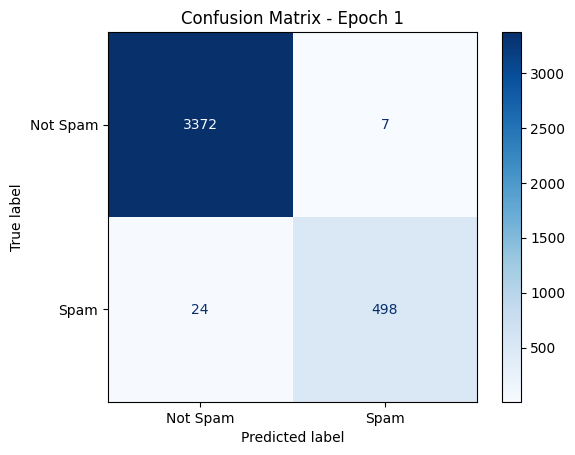

Epoch 2/3, Training Loss: 0.0381
Validation Metrics: Accuracy: 0.99, Precision: 0.95, Recall: 0.97, F1 Score: 0.96
Validation Loss: 0.0467


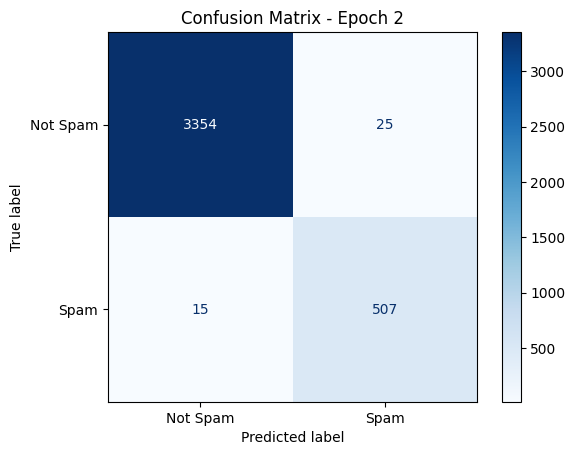

Epoch 3/3, Training Loss: 0.0274
Validation Metrics: Accuracy: 0.98, Precision: 0.90, Recall: 0.98, F1 Score: 0.94
Validation Loss: 0.0706


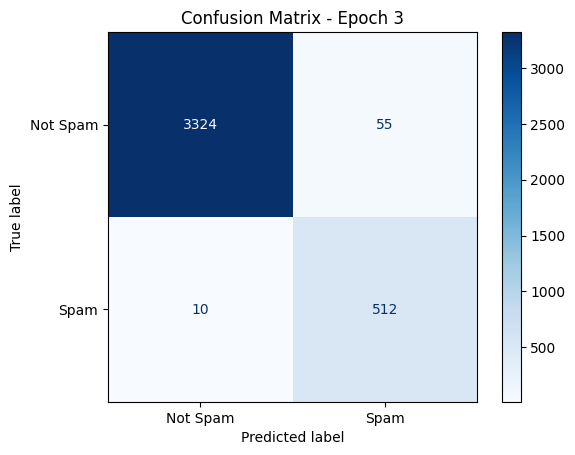

Review: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Predicted Label: Not Spam

Review: Ok lar... Joking wif u oni...
Predicted Label: Not Spam

Review: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Predicted Label: Spam

Review: U dun say so early hor... U c already then say...
Predicted Label: Not Spam

Review: Nah I don't think he goes to usf, he lives around here though
Predicted Label: Not Spam

Review: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Predicted Label: Spam

Review: Even my brother is not like to speak with me. They treat me like aids patent.
Predicted Label: Not Spam

Review: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers.

In [5]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define a custom dataset class
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        inputs = {key: value.squeeze(0) for key, value in encoding.items()}
        return inputs, torch.tensor(label, dtype=torch.long)

# Prepare the data
df = pd.read_csv('/content/drive/MyDrive/CS614/spam.csv', encoding = "ISO-8859-1")
texts = df['v2'].tolist()
labels = df['v1'].map({'ham': 0, 'spam': 1}).tolist()

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.7, random_state=42)

# Initialize tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_dataset = SMSDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = SMSDataset(val_texts, val_labels, tokenizer, max_len=128)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load pre-trained BERT model with an additional classification layer
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

# Move model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define training function
# Define training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            inputs, labels = batch
            inputs = {key: value.to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            optimizer.zero_grad() # Zero gradients before forward pass
            outputs = model(**inputs, labels=labels) # Pass labels to the model
            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

        # Validate the model
        model.eval()
        val_preds, val_labels_list = [], []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = {key: value.to(device) for key, value in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs, labels=labels) # Pass labels to the model during validation
                loss = outputs.loss
                if loss is not None: # Check if loss is calculated
                    total_val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                val_preds.extend(preds)
                val_labels_list.extend(labels.cpu().numpy())

        if len(val_loader) > 0: # Avoid division by zero if val_loader is empty
            avg_val_loss = total_val_loss / len(val_loader)
        else:
            avg_val_loss = 0.0
        accuracy = accuracy_score(val_labels_list, val_preds)
        precision = precision_score(val_labels_list, val_preds)
        recall = recall_score(val_labels_list, val_preds)
        f1 = f1_score(val_labels_list, val_preds)

        print(f"Validation Metrics: Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Display Confusion Matrix
        conf_matrix = confusion_matrix(val_labels_list, val_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Spam', 'Spam'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        plt.show()

# Train the model
train(model, train_loader, val_loader, optimizer, epochs=3)

# Predict on new reviews
def predict_reviews(reviews):
    inputs = tokenizer(reviews, truncation=True, padding='max_length', return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    label_map = {0: 'Not Spam', 1: 'Spam'}
    predicted_classes = [label_map[label] for label in predictions]
    return predicted_classes

# Define new reviews for prediction
new_reviews = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "U dun say so early hor... U c already then say...",
    "Nah I don't think he goes to usf, he lives around here though",
    "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
    "Even my brother is not like to speak with me. They treat me like aids patent.",
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
    "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]

predicted_labels = predict_reviews(new_reviews)

# Print the predictions
for review, label in zip(new_reviews, predicted_labels):
    print(f"Review: {review}\nPredicted Label: {label}\n")


In [6]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define a custom dataset class
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        inputs = {key: value.squeeze(0) for key, value in encoding.items()}
        return inputs, torch.tensor(label, dtype=torch.long)

# Prepare the data
df = pd.read_csv('/content/drive/MyDrive/CS614/spam.csv', encoding = "ISO-8859-1")
texts = df['v2'].tolist()
labels = df['v1'].map({'ham': 0, 'spam': 1}).tolist()

# Split the data into train and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initialize tokenizer and dataset
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
train_dataset = SMSDataset(train_texts, train_labels, tokenizer, max_len=128)
val_dataset = SMSDataset(val_texts, val_labels, tokenizer, max_len=128)

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load pre-trained BERT model with an additional classification layer
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

# Move model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    model.train()
    for epoch in range(epochs):
        for batch in train_loader:
            inputs, labels = batch
            inputs = {key: value.to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels) # Pass labels to the model
            loss = outputs.loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{epochs}, Loss: {loss.item()}")

        # Validate the model
        model.eval()
        val_preds, val_labels = [], []
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = {key: value.to(device) for key, value in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs)
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                val_preds.extend(preds)
                val_labels.extend(labels.cpu().numpy())

        accuracy = accuracy_score(val_labels, val_preds)
        precision = precision_score(val_labels, val_preds)
        recall = recall_score(val_labels, val_preds)
        f1 = f1_score(val_labels, val_preds)

        print(f"Validation Metrics: Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")

# Train the model
train(model, train_loader, val_loader, optimizer, epochs=3)

# Predict on new reviews
def predict_reviews(reviews):
    inputs = tokenizer(reviews, truncation=True, padding='max_length', return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    label_map = {0: 'Not Spam', 1: 'Spam'}
    predicted_classes = [label_map[label] for label in predictions]
    return predicted_classes

# Define new reviews for prediction
new_reviews = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "U dun say so early hor... U c already then say...",
    "Nah I don't think he goes to usf, he lives around here though",
    "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
    "Even my brother is not like to speak with me. They treat me like aids patent.",
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
    "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]

predicted_labels = predict_reviews(new_reviews)

# Print the predictions
for review, label in zip(new_reviews, predicted_labels):
    print(f"Review: {review}\nPredicted Label: {label}\n")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Loss: 0.0021067741326987743
Validation Metrics: Accuracy: 0.99, Precision: 0.95, Recall: 0.97, F1 Score: 0.96
Epoch 2/3, Loss: 0.0014904800336807966
Validation Metrics: Accuracy: 0.99, Precision: 0.95, Recall: 0.97, F1 Score: 0.96
Epoch 3/3, Loss: 0.0012566159712150693
Validation Metrics: Accuracy: 0.99, Precision: 0.99, Recall: 0.97, F1 Score: 0.98
Review: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Predicted Label: Not Spam

Review: Ok lar... Joking wif u oni...
Predicted Label: Not Spam

Review: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Predicted Label: Spam

Review: U dun say so early hor... U c already then say...
Predicted Label: Not Spam

Review: Nah I don't think he goes to usf, he lives around here though
Predicted Label: Not Spam

Review: FreeMsg Hey there darling it's been 3 week's now

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/3, Training Loss: 0.0867
Validation Metrics: Accuracy: 0.98, Precision: 0.95, Recall: 0.94, F1 Score: 0.94
Validation Loss: 0.0424


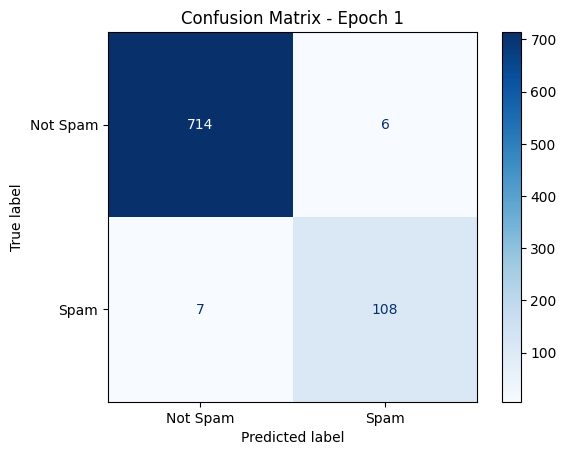

Epoch 2/3, Training Loss: 0.0216
Validation Metrics: Accuracy: 0.98, Precision: 0.89, Recall: 0.97, F1 Score: 0.93
Validation Loss: 0.0837


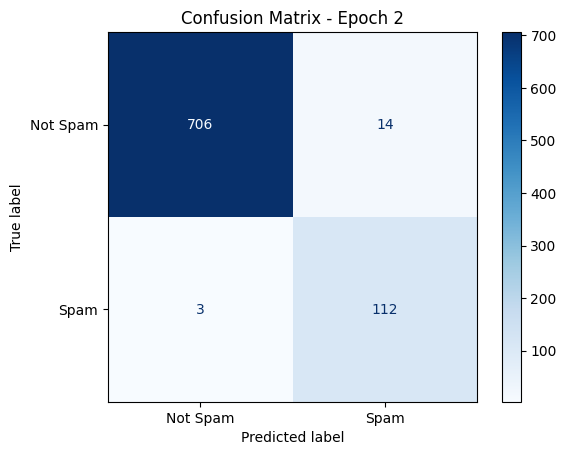

Epoch 3/3, Training Loss: 0.0175
Validation Metrics: Accuracy: 0.99, Precision: 0.99, Recall: 0.92, F1 Score: 0.95
Validation Loss: 0.0661


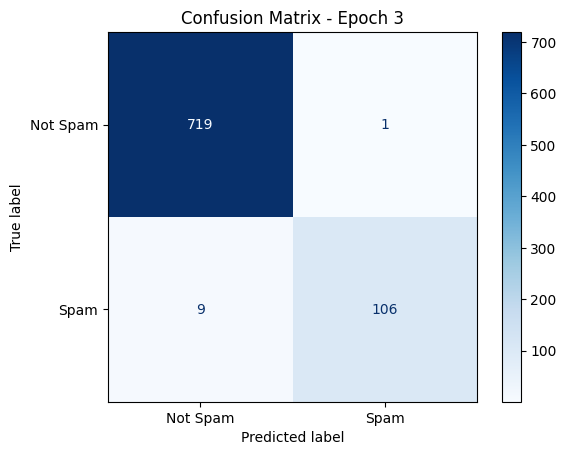


Final Test Metrics:
Accuracy: 0.99
Precision: 0.98
Recall: 0.95
F1 Score: 0.96

Confusion Matrix:
[[735   2]
 [  5  95]]


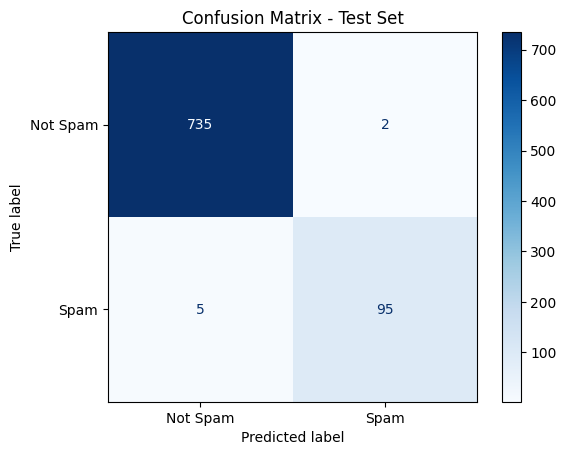

Review: Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Predicted Label: Not Spam

Review: Ok lar... Joking wif u oni...
Predicted Label: Not Spam

Review: Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
Predicted Label: Spam

Review: U dun say so early hor... U c already then say...
Predicted Label: Not Spam

Review: Nah I don't think he goes to usf, he lives around here though
Predicted Label: Not Spam

Review: FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
Predicted Label: Spam

Review: Even my brother is not like to speak with me. They treat me like aids patent.
Predicted Label: Not Spam

Review: As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers.

In [7]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Define a custom dataset class
class SMSDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(
            text,
            truncation=True,
            padding='max_length',
            max_length=self.max_len,
            return_tensors='pt'
        )
        inputs = {key: value.squeeze(0) for key, value in encoding.items()}
        return inputs, torch.tensor(label, dtype=torch.long)

# Prepare the data
df = pd.read_csv('/content/drive/MyDrive/CS614/spam.csv', encoding = "ISO-8859-1")
texts = df['v2'].tolist()
labels = df['v1'].map({'ham': 0, 'spam': 1}).tolist()

# Split the data into train (70%), validation (15%), and test (15%) sets
train_size = int(0.7 * len(texts))
val_size = int(0.15 * len(texts))
test_size = len(texts) - train_size - val_size

dataset = SMSDataset(texts, labels, BertTokenizer.from_pretrained('bert-base-cased'), max_len=128)
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Define DataLoaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
test_loader = DataLoader(test_dataset, batch_size=16)

# Load pre-trained BERT model with an additional classification layer
model = BertForSequenceClassification.from_pretrained('bert-base-cased', num_labels=2)

# Move model to device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define optimizer
optimizer = AdamW(model.parameters(), lr=5e-5)

# Define training function
def train(model, train_loader, val_loader, optimizer, epochs=3):
    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_loader:
            inputs, labels = batch
            inputs = {key: value.to(device) for key, value in inputs.items()}
            labels = labels.to(device)

            outputs = model(**inputs, labels=labels) # Pass labels for training
            loss = outputs.loss
            total_loss += loss.item()
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        avg_train_loss = total_loss / len(train_loader)
        print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {avg_train_loss:.4f}")

        # Validate the model
        model.eval()
        val_preds, val_labels_list = [], []
        total_val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                inputs, labels = batch
                inputs = {key: value.to(device) for key, value in inputs.items()}
                labels = labels.to(device)

                outputs = model(**inputs, labels=labels) # Pass labels for validation loss calculation
                loss = outputs.loss
                total_val_loss += loss.item()
                logits = outputs.logits
                preds = torch.argmax(logits, dim=-1).cpu().numpy()
                val_preds.extend(preds)
                val_labels_list.extend(labels.cpu().numpy())

        avg_val_loss = total_val_loss / len(val_loader)
        accuracy = accuracy_score(val_labels_list, val_preds)
        precision = precision_score(val_labels_list, val_preds)
        recall = recall_score(val_labels_list, val_preds)
        f1 = f1_score(val_labels_list, val_preds)

        print(f"Validation Metrics: Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1 Score: {f1:.2f}")
        print(f"Validation Loss: {avg_val_loss:.4f}")

        # Display Confusion Matrix
        conf_matrix = confusion_matrix(val_labels_list, val_preds)
        disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Spam', 'Spam'])
        disp.plot(cmap=plt.cm.Blues)
        plt.title(f'Confusion Matrix - Epoch {epoch + 1}')
        plt.show()

# Train the model
train(model, train_loader, val_loader, optimizer, epochs=3)

# Evaluate the model on the test set
model.eval()
test_preds, test_labels_list = [], []
with torch.no_grad():
    for batch in test_loader:
        inputs, labels = batch
        inputs = {key: value.to(device) for key, value in inputs.items()}
        labels = labels.to(device)

        outputs = model(**inputs)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=-1).cpu().numpy()
        test_preds.extend(preds)
        test_labels_list.extend(labels.cpu().numpy())

# Calculate final metrics
accuracy = accuracy_score(test_labels_list, test_preds)
precision = precision_score(test_labels_list, test_preds)
recall = recall_score(test_labels_list, test_preds)
f1 = f1_score(test_labels_list, test_preds)
conf_matrix = confusion_matrix(test_labels_list, test_preds)

print("\nFinal Test Metrics:")
print(f"Accuracy: {accuracy:.2f}")
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print("\nConfusion Matrix:")
print(conf_matrix)

# Display Confusion Matrix for test set
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Not Spam', 'Spam'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Test Set')
plt.show()

# Predict on new reviews
def predict_reviews(reviews):
    inputs = tokenizer(reviews, truncation=True, padding='max_length', return_tensors='pt')
    inputs = {key: value.to(device) for key, value in inputs.items()}

    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)

    logits = outputs.logits
    predictions = torch.argmax(logits, dim=-1).cpu().numpy()

    label_map = {0: 'Not Spam', 1: 'Spam'}
    predicted_classes = [label_map[label] for label in predictions]
    return predicted_classes

# Define new reviews for prediction
new_reviews = [
    "Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...",
    "Ok lar... Joking wif u oni...",
    "Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's",
    "U dun say so early hor... U c already then say...",
    "Nah I don't think he goes to usf, he lives around here though",
    "FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv",
    "Even my brother is not like to speak with me. They treat me like aids patent.",
    "As per your request 'Melle Melle (Oru Minnaminunginte Nurungu Vettam)' has been set as your callertune for all Callers. Press *9 to copy your friends Callertune",
    "WINNER!! As a valued network customer you have been selected to receive a £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only."
]

predicted_labels = predict_reviews(new_reviews)

# Print the predictions
for review, label in zip(new_reviews, predicted_labels):
    print(f"Review: {review}\nPredicted Label: {label}\n")
